<a href="https://colab.research.google.com/github/skbhere/Foot-or-not-CNN-Binary-classifier-/blob/master/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

In [2]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

17227776/17225924 [==============================] - 0s 0us/step


In [3]:
preprocessed_image = prepare_image('Lighthouse.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

40960/35363 [==================================] - 0s 0us/step


[[('n02814860', 'beacon', 0.83203715),
  ('n02980441', 'castle', 0.1304102),
  ('n03781244', 'monastery', 0.012002675),
  ('n03028079', 'church', 0.00917956),
  ('n09399592', 'promontory', 0.0034800267)]]

In [31]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='sigmoid')(x) #final layer with softmax activation

In [32]:
model=Model(inputs=base_model.input,outputs=preds)

In [33]:
# for i,layer in enumerate(model.layers):
#   # print(i,layer.name)

In [34]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/data/foot or not/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 shuffle=True)

Found 293 images belonging to 2 classes.


In [37]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
9/9 [==============================] - 31s 3s/step - loss: 0.8111 - accuracy: 0.7625
Epoch 2/10
9/9 [==============================] - 31s 3s/step - loss: 0.0247 - accuracy: 0.9847
Epoch 3/10
9/9 [==============================] - 31s 3s/step - loss: 0.0085 - accuracy: 0.9962
Epoch 4/10
9/9 [==============================] - 31s 3s/step - loss: 0.0305 - accuracy: 0.9885
Epoch 5/10
9/9 [==============================] - 31s 3s/step - loss: 0.2351 - accuracy: 0.9617
Epoch 6/10
9/9 [==============================] - 31s 3s/step - loss: 0.1151 - accuracy: 0.9464
Epoch 7/10
9/9 [==============================] - 31s 3s/step - loss: 0.0165 - accuracy: 0.9923
Epoch 8/10
9/9 [==============================] - 34s 4s/step - loss: 0.0033 - accuracy: 1.0000
Epoch 9/10
9/9 [==============================] - 31s 3s/step - loss: 3.9600e-04 - accuracy: 1.0000
Epoch 10/10
9/9 [==============================] - 31s 3s/step - loss: 6.8235e-05 - accuracy: 1.0000


In [78]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = '/content/gettyimages-475975168-612x612.jpg'
new_image = load_image(img_path)

pred = model.predict(new_image)

pred

array([[4.5848083e-07]], dtype=float32)

In [40]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


Saved model to disk


Loaded model from disk


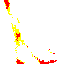

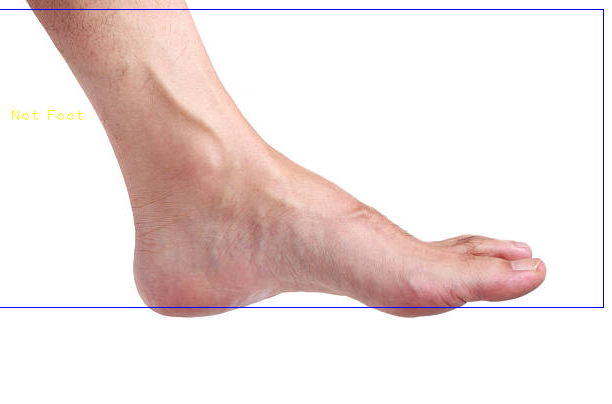

In [74]:
import numpy as np
from keras.models import model_from_json
import operator
import cv2
import sys, os
from google.colab.patches import cv2_imshow
# Loading the model
json_file = open("model.json", "r")
model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# cap = cv2.VideoCapture(0)
net =cv2.dnn.readNetFromDarknet()
# Category dictionary
categories = {0: 'Foot', 1: 'Not a Foot'}

# while True:
# _, frame = cap.read()
# Simulating mirror image
img_path = "/content/gettyimages-156974307-612x612.jpg"
frame = cv2.imread(img_path)
frame = cv2.flip(frame, 1)

# Got this from collect-data.py
# Coordinates of the ROI
x1 -= int(0.5*frame.shape[1])
y1 = 10
x2 = frame.shape[1]-10
y2 = int(0.5*frame.shape[1])
# Drawing the ROI
# The increment/decrement by 1 is to compensate for the bounding box
cv2.rectangle(frame, (x1-1, y1-1), (x2+1, y2+1), (255,0,0) ,1)
# Extracting the ROI
roi = frame[y1:y2, x1:x2]

# Resizing the ROI so it can be fed to the model for prediction
roi = cv2.resize(roi, (64, 64)) 
# roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
_, test_image = cv2.threshold(roi, 120, 255, cv2.THRESH_BINARY)
cv2_imshow( test_image)
# Batch of 1
new_image = load_image(img_path)
result = loaded_model.predict(new_image)
if result[0][0]>0.5:
    prediction = {'Foot': result[0][0],  
              }
else:
    prediction = {'Not Foot': result[0][0],  
              }

# Sorting based on top prediction
prediction = sorted(prediction.items(), key=operator.itemgetter(1), reverse=True)

# Displaying the predictions
cv2.putText(frame, prediction[0][0], (10, 120), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,255), 1)    
cv2_imshow( frame)

# interrupt = cv2.waitKey(10)
# if interrupt & 0xFF == 27: # esc key
#     break
        
 
# cap.release()
cv2.destroyAllWindows()

In [75]:
result[0][0]

7.376686e-13